In [2]:
import torch
import torchvision
from torchvision import transforms as T
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = 'C://Users/seriy/tmp'
BATCH_SIZE = 16

RAND_SEED = 42
torch.manual_seed(RAND_SEED)
np.random.seed(RAND_SEED)

## Prepare i.d. data for training and testing

In [4]:
from torchvision import datasets, transforms
transform = transforms.Compose([transforms.Resize((224, 224)), # resize for imagenet pretrained model
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                                ])
trainset = datasets.MNIST(DATA_DIR, download=True, train=True, transform=transform)
testset = datasets.MNIST(DATA_DIR, download=True, train=False, transform=transform)

Draw samples from **MNIST** dataset

In [5]:
def draw_mnist_batch(x, y_true, y_pred=None):
    
    if y_true.size(dim=0) > BATCH_SIZE:
        x = x[:BATCH_SIZE, :, :, :]
        y_true = y_true[:BATCH_SIZE]
        if y_pred is not None:
            y_pred = y_pred[:BATCH_SIZE]
    
    fig, axes = plt.subplots(1, 6, figsize=(10, 4))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(x[i].numpy().squeeze(), cmap='gray')
        if y_pred is None:
            ax.set_title(f"true: {y_true[i]}")
        else:
            ax.set_title(f"pred: {y_pred[i]}, true: {y_true[i]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [6]:
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

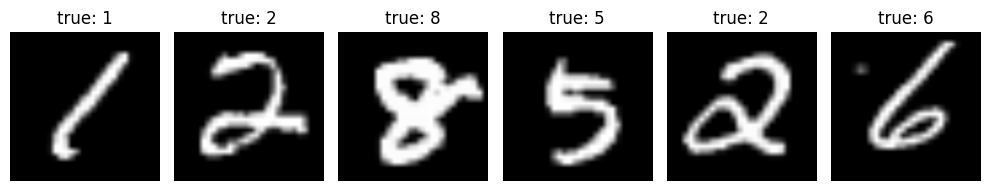

In [7]:
x, y_true = next(iter(train_loader))
draw_mnist_batch(x, y_true)

Let's use a pretrained classifier, EfficientNetV2, finetune it for couple of epochs and verify that it's performance is *satisfactory* for our MNIST task.

In [8]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        pretrained_clf = torchvision.models.efficientnet_b1(weights=torchvision.models.EfficientNet_B1_Weights.IMAGENET1K_V1)
        self.backbone = nn.Sequential(*list(pretrained_clf.children())[:-1])
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(1280, 10)
        nn.init.xavier_uniform_(self.classifier.weight)
    
    def forward(self, x):
        x = torch.broadcast_to(x, (x.size(0), 3, 224, 224)) # 1 channel to 3 channels
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

model = Model()

In [75]:
LR_RATE = 3e-3
WARM_UP_EPOCHS = 5
EPOCHS = 20

from tqdm import tqdm
from sklearn.metrics import f1_score

@torch.no_grad()
def evaluate(model: Model, train_loader, test_loader):
    eval_res = dict()
    model.eval()
    for name, loader in zip(["train", "test"], [train_loader, test_loader]):
        accuracy = 0
        f1 = 0
        loss = 0
        for x, y_true in loader:
            x = x.to(DEVICE)
            y_true = y_true.to(DEVICE)
            logits = model(x)
            y_pred = logits.argmax(dim=1)
            accuracy += (y_pred == y_true).sum().item()
            f1 += f1_score(y_true.cpu().numpy(), y_pred.cpu().numpy(), average='macro')
            loss += F.cross_entropy(logits, y_true).item()
        eval_res[name + '_loss'] = loss / len(loader)
        eval_res[name + '_accuracy'] = accuracy / len(loader.dataset)
        eval_res[name + '_f1'] = f1 / len(loader)
        # f1_score is averaged over batches, it's not true, but a good approximation
    
    model.train()
    return eval_res
        

def train_model(model, train_loader, test_loader):
    """Train model in two stages, log everything, save by best f1-macro on test"""
    optimizer = torch.optim.Adam(model.parameters(), lr=LR_RATE)
    criterion = nn.CrossEntropyLoss()
    eval_hist = []
    best_f1 = 0.

    model.train()
    # warm up stage
    for p in model.backbone.parameters():
        p.requires_grad = False

    for e in range(WARM_UP_EPOCHS):
        with tqdm(train_loader, unit="batch") as tepoch:
            for x, y_true in tepoch:
                tepoch.set_description(f"Warm up epoch {e+1}/{WARM_UP_EPOCHS}")

                x = x.to(DEVICE)
                y_true = y_true.to(DEVICE)
                y_pred = model(x)
                loss = criterion(y_pred, y_true)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                tepoch.set_postfix(loss=loss.item())
            print(f"Warm up epoch {e+1}/{WARM_UP_EPOCHS} done")

    # fine tuning stage
    for p in model.backbone.parameters():
        p.requires_grad = True
    
    for e in range(EPOCHS):
        with tqdm(train_loader, unit="batch") as tepoch:
            for x, y_true in tepoch:
                tepoch.set_description(f"Epoch {e+1}/{EPOCHS}")
                
                x = x.to(DEVICE)
                y_true = y_true.to(DEVICE)
                y_pred = model(x)
                loss = criterion(y_pred, y_true)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                tepoch.set_postfix(loss=loss.item())
            if e % 3 == 0:
                eval_res = evaluate(model, train_loader, test_loader)
                eval_hist.append(eval_res)
                print(f"Epoch {e+1}/{EPOCHS} done")
                print(f"Train loss: {eval_res['train_loss']:.4f}, accuracy: {eval_res['train_accuracy']:.4f}, f1: {eval_res['train_f1']:.4f}")
                print(f"Test loss: {eval_res['test_loss']:.4f}, accuracy: {eval_res['test_accuracy']:.4f}, f1: {eval_res['test_f1']:.4f}")
                if eval_res['test_f1'] > best_f1:
                    best_f1 = eval_res['test_f1']
                    torch.save(model.state_dict(), 'model/model.pt')

    return eval_hist

In [10]:
model = model.to(DEVICE)
#train_model(model, train_loader, test_loader)

In [76]:
# load saved model
model = Model().to(DEVICE)
model.load_state_dict(torch.load('model/model.pt'))
evaluate(model, train_loader, test_loader)

{'train_loss': 0.002934473032908526,
 'train_accuracy': 0.9989833333333333,
 'train_f1': 0.9983266483122992,
 'test_loss': 0.020448148881274154,
 'test_accuracy': 0.994,
 'test_f1': 0.990334838635791}

Now lets create **o.o.d.** data. We will create it by applying following transformations
- downscale (make numbers smaller and fill edges with default background)
- rotate  by -$\pi$/12
- linearly interpolate with gaussian noise

In [10]:
class OOD_MNIST(Dataset):
    def __init__(self):
        self.dataset = testset
        self.w = 0.97

    def _ood_transform(self, x):
        # pad image and resize to 32x32
        h, w = x.size(-2), x.size(-1)
        p = int(max(h, w)*0.15)
        x = TF.pad(x, padding=p, fill=-1, padding_mode='constant')
        x = TF.resize(x, size=(h, w))
        # rotate by 15 degrees to right, fill with 0
        x = TF.rotate(x, angle=-15, fill=-1)
        # linearly interpolate with normal noise
        x = self.w*x + (1-self.w)*torch.randn_like(x)
        return x

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        x = self._ood_transform(x)
        return x, y
    
ood_dataset = OOD_MNIST()
ood_loader = DataLoader(ood_dataset, batch_size=BATCH_SIZE, shuffle=False)

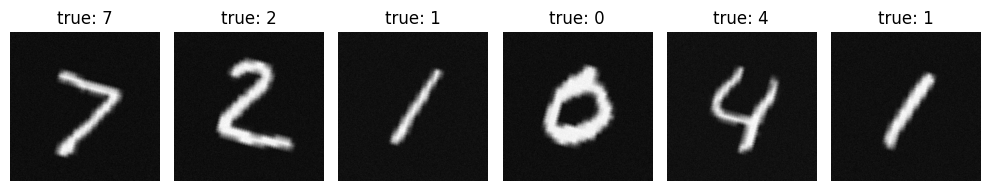

In [11]:
x, y_true = next(iter(ood_loader))
draw_mnist_batch(x, y_true)

This o.o.d. dataset is still handwritten numbers with same classes, however images have been created in little bit different setting. We are not doing random permutations because we are trying to deterministically shift a distribution of data in images.

Lets look at prediction made by our model:

In [14]:
evaluate(model, train_loader, ood_loader) # pass ood_loader as test_loader

{'train_loss': 0.0029344730513819303,
 'train_accuracy': 0.9989833333333333,
 'train_f1': 0.9984467394381045,
 'test_loss': 1.3025460997581482,
 'test_accuracy': 0.6362,
 'test_f1': 0.5525892384156974}

Quality on new test o.o.d. data is not great. This is logical, since our model has not been trained on this data. But we wouldn't be able to tell that without manual annotation of o.o.d. data and analyzing it's performance in experiment setting. 

Lets study the distributions of last layer activation functions and also the distributions of scoring function. We will use Mahalanobis distance metric as a score for o.o.d. detection (source: [A Simple Unified Framework for Detecting Out-of-Distribution Samples and Adversarial Attacks](https://arxiv.org/pdf/1807.03888.pdf)

In [13]:
@torch.no_grad()
def calculate_mean_and_covariance(model, train_loader):
    model.eval()
    logits = []
    labels = []
    for x, y in train_loader:
        x = x.to(DEVICE)
        logits.append(model(x))
        labels.append(y)
    logits = torch.cat(logits, dim=0)
    labels = torch.cat(labels, dim=0)

    means = []
    covs = []
    for i in range(10):
        class_logits = logits[labels == i]
        means.append(class_logits.mean(dim=0))
        covs.append(torch.cov(class_logits.T))
    means = torch.stack(means)
    covs = torch.stack(covs)
    return means, covs

means, covs = calculate_mean_and_covariance(model, train_loader)

In [14]:
means.shape, covs.shape

(torch.Size([10, 10]), torch.Size([10, 10, 10]))

Idea is simple: the less confident our model is over data, the greater the distance from the closest class cluster

In [77]:
some_id_samples = [testset[i] for i in range(500)]
some_ood_samples = [ood_dataset[i] for i in range(500)]

@torch.no_grad()
def score_maha(model, samples, means, covs):
    model.eval()
    scores = []
    for x, _ in samples:
        x = x.to(DEVICE)
        logit = model(x.unsqueeze(0))
        score = 1e6
        for (mean, cov) in zip(means, covs):
            score = min(score, torch.min(0.5 * (logit - mean) @ torch.inverse(cov) @ (logit - mean).T, dim=1)[0])
        scores.append(score)
    return torch.cat(scores)

id_scores = score_maha(model, some_id_samples, means, covs)
ood_scores = score_maha(model, some_ood_samples, means, covs)

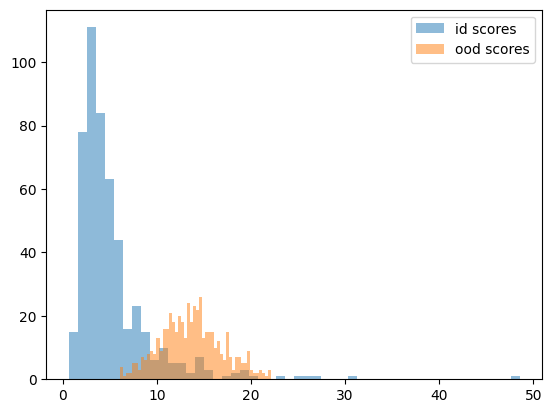

In [78]:
plt.hist(id_scores.cpu().numpy(), bins=50, alpha=0.5, label='id scores')
plt.hist(ood_scores.cpu().numpy(), bins=50, alpha=0.5, label='ood scores')
plt.legend()
plt.show()

Now lets apply react. For that we will alter our model code with some modifications by creating a child class and adding some functionality.

In [87]:
class ReAct(nn.Module):
    def __init__(self, truncate_activations=False, c=7.5):
        super().__init__()
        self.truncate_activations = truncate_activations
        self.register_buffer("c", torch.tensor([c]))

    def forward(self, x):
        if self.truncate_activations:
            x = torch.clamp(x, max=self.c)
        return x    

class ModelWithReAct(Model):
    def __init__(self, pretrained_model_weights, truncate_activations=False):
        super().__init__()
        self.load_state_dict(torch.load(pretrained_model_weights))
        react = ReAct(truncate_activations)
        self.pre_act_backbone = self.backbone[:-1]
        self.react = react
        self.post_act_backbone = self.backbone[-1:]
        self.backbone[-2][-1] = nn.Sequential(self.backbone[-2][-1], react)
    
    def forward(self, x):
        return super().forward(x)
    
    def extract_activation_unit_values(self, x):
        x = torch.broadcast_to(x, (x.size(0), 3, x.size(-2), x.size(-1)))
        activations = self.pre_act_backbone(x)
        activations = torch.flatten(activations, 1)
        return activations

In [88]:
react_model = ModelWithReAct('model/model.pt', truncate_activations=True)
react_model = react_model.to(DEVICE)

In [ ]:
@torch.no_grad()
def get_mean_and_std_of_activation_units(model, samples):
    model.eval()
    mean_act = torch.zeros(size=(62720))
    mean_squared_act = mean_act = torch.zeros(size=(62720))
    for i, (x, y) in enumerate(samples):
        x = x.to(DEVICE)
        x = x.unsqueeze(0)
        act_values = model.extract_activation_unit_values()
        if i > 0:
            mean_act = mean_act*()
        else:
            mean_act = act_values
            mean_squared_act = torch.pow(act_values, 2)
    std_act = torch.pow(mean_squared_act - torch.pow(mean_act, 2), 0.5)
    return  mean_act, std_act       

So, that is it. No training needed, lets jump in and apply ReAct-ed model to our dataset and observe change in score distributions (of course it is prefered to perform a careful selection via grid-search of c-value, so that quality on i.d. data doesn't change, but I simply guessed it)

In [89]:
react_id_scores = score_maha(react_model, some_id_samples, means, covs)
react_ood_scores = score_maha(react_model, some_ood_samples, means, covs)

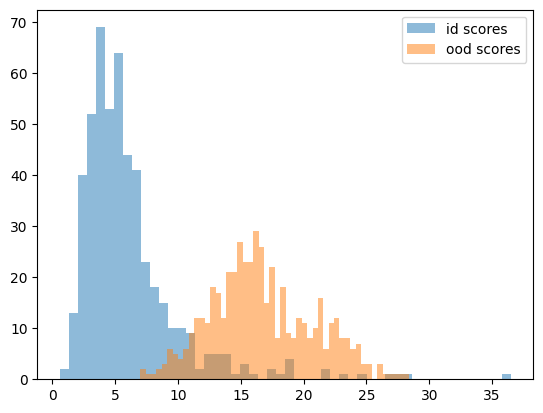

In [90]:
plt.hist(react_id_scores.cpu().numpy(), bins=50, alpha=0.5, label='id scores')
plt.hist(react_ood_scores.cpu().numpy(), bins=50, alpha=0.5, label='ood scores')
plt.legend()
plt.show()

As we can see, after truncating activation values, our ditributions became a lot more distinguishable, with much more defined mean values.